In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

# 做一个方腔流
Nx   = 100
Ny   = 100
rho0 = 100 # 为什么平均密度是100
tau  = 0.6 # 松弛时间
Nt   = 10000 # 迭代次数

plotRealTime = True

#Lattice speeds / weights
NL = 9

F = np.zeros((Nx, Ny, NL)) # 速度分布函数

rho0 = 5 #初始密度
u0 = 0.1 #初始速度

niu = 0.01 #

Re = u0*Ny/niu #雷诺数

Ntstep = 40000
w = np.array([4/9] + [1/9]*4 + [1/36]*4) #权重
cx = np.array([0, 1, 0, -1, 0, 1, -1, -1, 1]) #速度分量
cy = np.array([0, 0, 1, 0, -1, 1, 1, -1, -1]) #速度分量

rho = np.ones((Nx, Ny)) * rho0 #密度分布函数

u = np.zeros((Nx, Ny)) #x 上的速度分布函数
v = np.zeros((Nx, Ny)) #y 上的速度分布函数


u[:,-1] = u0 #初始速度分布函数
u[0,0] = 0 # 这一步会影响吗

omega = 1/(3*niu + 0.5) #松弛时间

cs  = 1/np.sqrt(3) #声速
cs2 = np.power(cs,2) #声速平方
for t in range(Ntstep): 

    # 先进行碰撞
    #print("t=",t)
    for i in range(NL):
        cu = cx[i]*u + cy[i]*v #速度分布函数
        feq = rho * w[i] * (1 + cu/cs2 + cu**2/(2*cs2**2) - (u**2 + v**2)/(2*cs2) ) #平衡分布函数
        F[:,:,i] = (1 - omega) * F[:,:,i] + (omega) * feq #碰撞


    # 进行迁移
    # 联系迁移和边界条件反射同时理解
    F = Streaming(F,NL,cx,cy) #迁移函数
    F = BoundaryCondition(F,u0)# 进行边界条件处理
    
    #重新计算流场和密度场
    rho = np.sum(F,axis=2) #对k=0...8所有方向求和
    
    rho[1:-1,-1] = F[1:-1,-1,0] +F[1:-1,-1,1]+F[1:-1,-1,3] + 2*(F[1:-1,-1,2] +F[1:-1,-1,6] + F[1:-1,-1,5] )  
    
    u = np.sum(F[:,:,[1,5,8]]-F[:,:,[3,6,7]],axis=2) /3/ rho #对k=0...8所有方向求和
    v = np.sum(F[:,:,[2,5,6]]-F[:,:,[4,7,8]],axis=2) /3/ rho #对k=0...8所有方向求和
    #u[1:,1:-1] = np.sum(F[1:,1:-1,:]*cx,axis=2) / rho[1:,1:-1] #对k=0...8所有方向求和

    #v[1:,1:-1] = np.sum(F[1:,1:-1,:]*cy,axis=2) / rho[1:,1:-1] #对k=0...8所有方向求和







In [79]:
def Streaming( F ,NL,cx,cy) -> np.ndarray:
    # 尝试写一个笨拙的迁移操作
    # 要额外处理边界的部分
    """""
    for i in range(NL):
        # 剩余的边界
        F[1:,:,1]     = F[0:-1:1,:,1] 
        F[:,1:, 2]    = F[:,0:-1:1,2]  
        F[0:-1:1,:,3] = F[1:,:,3] 
        F[:,0:-1:1,4] = F[:,1:,4]
        F[1:,1:,5]    = F[0:-1: ,0:-1 ,5]

        F[:-1,1:, 6] = F[1:,:-1,6]
        F[:-1,:-1,7] = F[1:,1:,7]
        F[1:,:-1, 8] = F[:-1,1:,8]
    """
    NL = np.arange(NL) # 速度分布函数的索引
    for i, cx, cy in zip(NL, cx, cy):
         F[:,:,i] = np.roll(F[:,:,i], cx, axis=0)
         F[:,:,i] = np.roll(F[:,:,i], cy, axis=1)

    return F
def BoundaryCondition(F,uo):
    # 处理边界条件
    
    F[0,:,1] = F[0,:,3]    
    F[0,:,5] = F[0,:,7] 
    F[0,:,8] = F[0,:,6]

    F[-1,:,3] = F[-1,:,1] 
    F[-1,:,7] = F[-1,:,5]
    F[-1,:,6] = F[-1,:,8]

    F[:,0,2] = F[:,0,4]
    F[:,0,5] = F[:,0,7]
    F[:,0,6] = F[:,0,8]

    # slide 边界条件
    rhon = F[ 1:-1, -1, 0]  + F[ 1:-1 ,-1 ,1] + F[1:-1, -1,3]  + 2*(F[1:-1,-1,2]+F[1:-1,-1,6]+F[1:-1,-1,5])

    F[1:-1,-1,4] = F[1:-1,-1,2]
    F[1:-1,-1,8] = F[1:-1,-1,6] + rhon*uo/6
    F[1:-1,-1,7] = F[1:-1,-1,5] - rhon*uo/6

    return F




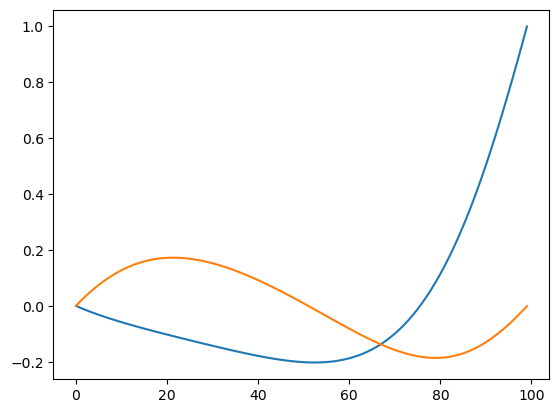

In [96]:
# 进行可视化分析
um = np.zeros(Ny)
vm = np.zeros(Ny)

um = u[ int(Nx/2 -1) , :]/u0
vm = v[ :, int(Ny/2 -1) ]/u0

VU = plt.figure()
plt.plot(np.arange(Ny),um, label='u')
plt.plot(np.arange(Nx),vm, label='v')

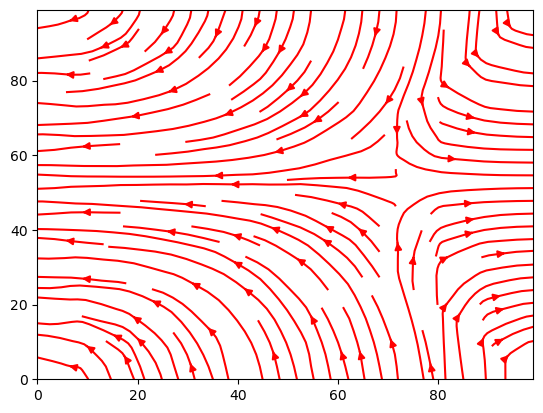

In [73]:
x = np.arange(Nx)
y = np.arange(Ny)
X, Y = np.meshgrid(x, y)

plt.streamplot(X,Y,u/u0,v/u0, color='r')

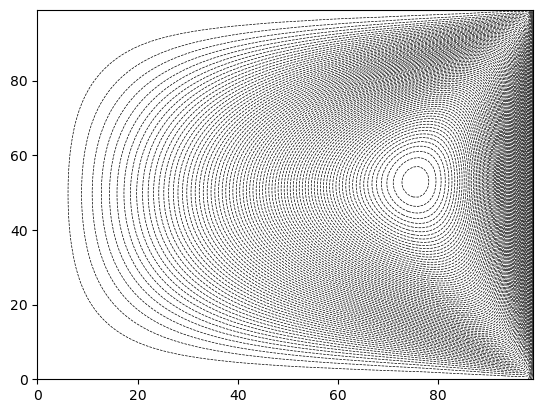

In [95]:
stream = np.zeros((Nx,Ny))
for i in range(Nx):
    for j in range(1,Ny):
        stream[i,j] = stream[i,j-1]+0.25*(rho[i][j]+rho[i,j-1])*(u[i][j]+u[i][j-1])   

plt.contour(X,Y,stream, levels=100, colors='k', linewidths=0.5)